Convergencia en 4302 iteraciones con error 9.99e-06


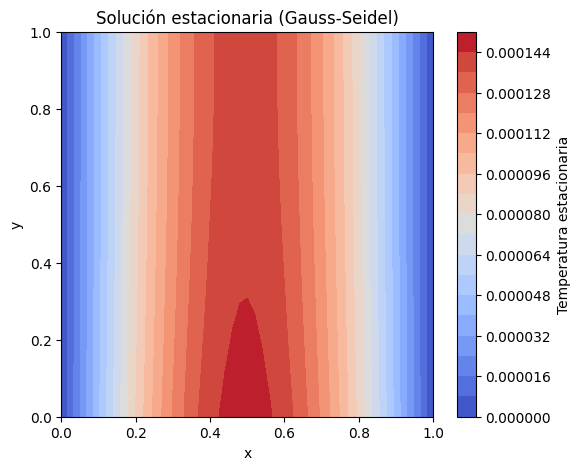

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
L = 1.0
N = 50
dx = L / N
tol = 1e-5
max_iter = 10000

# Malla
x = np.linspace(0, L, N+1)
y = np.linspace(0, L, N+1)
X, Y = np.meshgrid(x, y, indexing='ij')
T = np.zeros((N+1, N+1))

# Inicialización: opcional
T[:, :] = np.sin(np.pi * X) * np.sin(np.pi * Y)

# Iteración Gauss-Seidel
for it in range(max_iter):
    T_old = T.copy()

    for i in range(1, N):
        for j in range(1, N):
            T[i, j] = 0.25 * (T[i+1, j] + T[i-1, j] + T[i, j+1] + T[i, j-1])

    # Condiciones de frontera
    T[0, :] = 0
    T[N, :] = 0
    T[:, 0] = T[:, 1]      # y=0 aislado
    T[:, N] = T[:, N-1]    # y=L aislado

    error = np.linalg.norm(T - T_old)
    if error < tol:
        print(f'Convergencia en {it} iteraciones con error {error:.2e}')
        break
else:
    print("No convergió")

# Visualización
plt.figure(figsize=(6,5))
plt.contourf(X, Y, T, 20, cmap='coolwarm')
plt.colorbar(label='Temperatura estacionaria')
plt.title('Solución estacionaria (Gauss-Seidel)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


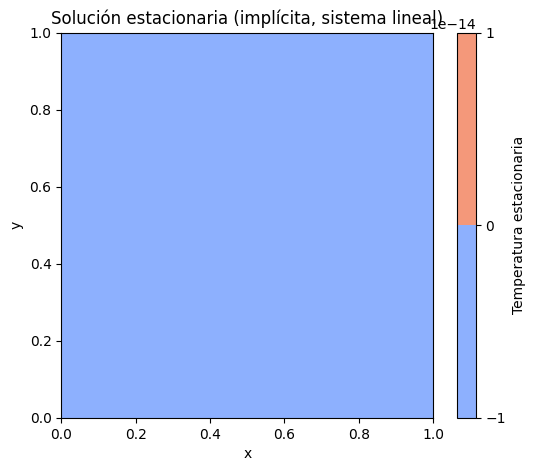

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# Parámetros
L = 1.0            # longitud del dominio
N = 50             # número de divisiones (N+1 puntos)
dx = L / N
dy = dx
Nint = (N-1)*(N+1)  # puntos interiores en x (excluyendo frontera)

# Malla
x = np.linspace(0, L, N+1)
y = np.linspace(0, L, N+1)
X, Y = np.meshgrid(x, y, indexing='ij')

# Función para indexar el punto (i, j) en el sistema lineal
def node(i, j):
    return (i - 1)*(N+1) + j

# Construcción de la matriz A y vector b
A = lil_matrix((Nint, Nint))
b = np.zeros(Nint)

for i in range(1, N):       # i = 1..N-1 (interior en x)
    for j in range(0, N+1): # j = 0..N (todo en y)
        idx = node(i, j)
        A[idx, idx] = -4

        # Punto a la derecha (i+1, j)
        if i < N-1:
            A[idx, node(i+1, j)] = 1
        else:
            # frontera x = L (T = 0)
            pass

        # Punto a la izquierda (i-1, j)
        if i > 1:
            A[idx, node(i-1, j)] = 1
        else:
            # frontera x = 0 (T = 0)
            pass

        # Punto arriba (i, j+1)
        if j < N:
            A[idx, node(i, j+1)] = 1
        else:
            # Neumann en y = L: T[i,N+1] = T[i,N-1]
            A[idx, node(i, j-1)] += 1

        # Punto abajo (i, j-1)
        if j > 0:
            A[idx, node(i, j-1)] = 1
        else:
            # Neumann en y = 0: T[i,-1] = T[i,1]
            A[idx, node(i, j+1)] += 1

# Resolver sistema lineal
T_flat = spsolve(A.tocsr(), b)

# Reconstruir la matriz 2D de temperatura
T = np.zeros((N+1, N+1))
k = 0
for i in range(1, N):
    for j in range(0, N+1):
        T[i, j] = T_flat[k]
        k += 1

# Aplicar condiciones de frontera
T[0, :] = 0        # x = 0
T[N, :] = 0        # x = L
T[:, 0] = T[:, 1]  # y = 0 (aislado)
T[:, N] = T[:, N-1]  # y = L (aislado)

# Visualización
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, T, 20, cmap='coolwarm')
plt.colorbar(label='Temperatura estacionaria')
plt.title('Solución estacionaria (implícita, sistema lineal)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
